# Basic Agent
* Goal: we will build a similar app to the one we built in the previous exercise. The main difference between this app and the previous one is that **here the tools node responds back to the assistant instead of going to the END Node**.
* This shows what is called the ReAct architecture: the LLM keeps using the tools until it gets a satisfactory response.
    * act - the LLM calls a tool.
    * observe - the tool passes the output back to the LLM.
    * reason - the LLM decides what to do next (call another tool or respond directly).

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 002-setup.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## LLM with several tools

In [12]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

# For this notebook we set parallel tool calling to false
# as math generally is done sequentially.
# The OpenAI model defaults to parallel tool calling for efficiency.
# You can learn more at https://python.langchain.com/docs/how_to/tool_calling_parallel/
llm_with_tools = chatModel4o.bind_tools(tools, parallel_tool_calls=False)

## Building an app (called graph in langgraph) that decides if chat with LLM or use tool

* Here you have a graphic representation of the app we will build:

![Simple graph](graph003.png)

## Define the State schema

* For this example, we will use the same MessagesState we used in the previous exercise:

In [7]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

## Define the first Node
* The Nodes of a graph are defined as python functions.
* The first argument of a Node function is the state. Because of that, in this exercise each node can access the key `messages`, with `state['messages']`.
* In this example, we will start with a node similar to the one we created in the previous exercise, **but this time with a SystemMessage**:

In [8]:
from langchain_core.messages import HumanMessage, SystemMessage

# System message, system prompt
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Combine Nodes and Edges to build the Graph
* First, we initialize a StateGraph with the `MessagesState` class we defined above.
* Then, we add our nodes and edges.
* The `START` Node is a special node that sends user input to the graph, to indicate where to start our graph.
* **See how we are using the ToolNode LangGraph built-in component to create the tool-using node called "tools"**.
    * We use ToolNode to call the tool. 
* **See how we are adding the conditional edge with the tools_condition LangGraph built-in component as our router**.
* **The main difference between this app and the previous one is that here the tools node responds back to the assistant instead of going to the `END` Node**.
    * This is what is called the ReAct architecture: the LLM keeps using the tools until it gets a satisfactory response.
        * act - the LLM calls a tool.
        * observe - the tool passes the output back to the LLM.
        * reason - the LLM decides what to do next (call another tool or respond directly).
* **See how we do not have `END` Node**.
* We compile our graph to perform a few basic checks on the graph structure.
* Finally, we visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

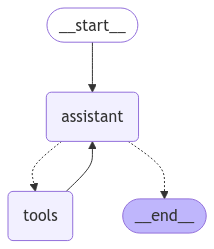

In [9]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add the logic of the graph
builder.add_edge(START, "assistant")

builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

# PAY ATTENTION HERE: from the tools node, back to the assistant
builder.add_edge("tools", "assistant")

# PAY ATTENTION: No END edge.

# Compile the graph
react_graph = builder.compile()

# Visualize the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Run the app
* The compiled graph implements the runnable protocol, a standard way to execute LangChain components. Because of that, we can use `invoke` as one of the standard methods to run this app.

In [10]:
messages = [HumanMessage(content="What was the relationship between Marilyn and JFK?")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What was the relationship between Marilyn and JFK?
================================== Ai Message ==================================

Marilyn Monroe and President John F. Kennedy (JFK) are often rumored to have had a romantic relationship, though concrete details about the nature and extent of their relationship remain speculative and are part of popular lore. The most famous public connection between them was Marilyn Monroe's sultry performance of "Happy Birthday, Mr. President" at a Democratic Party fundraiser and early birthday celebration for Kennedy in May 1962. However, both contemporaneous accounts and historical research have not conclusively proven a long-term affair, and much of the speculation is based on anecdotal evidence and hearsay.


In [11]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_UR7Cp0pbVpRyof8Dyq4kZUHm)
 Call ID: call_UR7Cp0pbVpRyof8Dyq4kZUHm
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_OiwYtGUW13AY8CB3qY3Y3Vlt)
 Call ID: call_OiwYtGUW13AY8CB3qY3Y3Vlt
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_pPlNCoLinv7gfbQu94bpkxnu)
 Call ID: call_pPlNCoLinv7gfbQu94bpkxnu
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

* **See that the previous operation performs the 3 sequential actions:**
    * Goes from assistant to tools and Adds 3 and 4. Goes back to assistant with the result.
    * Goes from assistant to tools and Multiplies the output by 2. Goes back to assistant with the result.
    * Goes from assistant to tools and Divides the output by 5. Goes back to assistant with the result.
    * Finally, it goes from assistant to End and prints the result.

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 006-basic-agent.py
* In terminal, make sure you are in the directory of the file and run:
    * python 006-basic-agent.py